### **Students' Knowledge Status**

**Group: Liam Brennan, Eva He, Li-Kun Lin, Steve He** 

Introduction:
The objective of any class should be to increase student’s understanding of the topic subject. Students with a high understanding of class material will enter the workforce with the tools they need to succeed in their relevant subjects. We will classify students' understanding of class materials based on five quantitative variables taken from Kahraman et al’s User Knowledge Modeling dataset.
The question our project will try to answer is : Can we predict student's knowledge level based on 5 different academic parameters using the Knn-classification algorithm?

Data Set information: 
The dataset was collected by Ka​​hraman et al. The weighting system and development of quantitative measurements for the variables was done using Kahramans rule based system which gives quantitative values(ratings) to students' performances in certain academic related parameters. The parameters:


STG: Refers to Study time rating(0-1), the amount time spend studying about Electrical DC Machines.

SCG: Refers to Repetition rating(0-1),  the amount of problems, material the student worked on. For example, worksheets, tutorials.

PEG: Refers to the exam performance rating of the subject(0-1), in this case, the exam performance on Electrical DC Machine course.

STR: Refers to Study time rating of related subjects(0-1), the amount of time students spent studying related topics.

LPR; Refers to exam performance rating in related subjects(0-1), exam performance on related material, or background information.

*UNS(): Refers to student understanding levels; Based on the weighting system Kahramans uses in his rule based system paper, classified  as “Very-low” “Low”, “Middle”, or “High” Understanding of Electrical DC Machines. 

Methods & Results:

### 1. loading in all the packages for data analysis
This analysis utilizes the knn classification algorithm to predict the knowledge level (High, Middle, Low or Very Low) of students. First, all the packages that are necessary to perform this algorithm are loaded into python.

In [1]:
install.packages("themis")
install.packages("kknn")
install.packages("cowplot")
library(kknn)
library(purrr)
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(cowplot)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ dplyr   1.1.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ tidyr   1.3.0     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ─────────────────────────────────────

### 2. Reading in the data from the web, and Preparation of Data analysis

#### (A) loading the data
After loading the data, we factorize the variable we want to predict, UNS, by using the function as.factor.

In [2]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

##Loading data
url <- "https://github.com/JackyLinllk/ubc_dsci100_assignment/raw/main/data/Data_User_Modeling_Dataset_full.csv"
knowledge_data<-read_csv(url)|>
    select(STG:UNS)|>
    mutate(UNS = as.factor(UNS))
knowledge_data

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
Rows: 404 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG
lgl (3): ...7, ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle
NA,NA,NA,NA,NA,NA


##### Table 1: Dataset Of Students' Knowledge Status
    This table represents the students' knowledge status about the subject of Electrical DC Machines. 
    For specific meaning of the columns refer back to the intro about the "Data set Information".

    The dataset had been obtained from: 
     Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). 
    User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

#### (B) NA-values
We then check for NA-values, and realized that the last row restores NA-values across all the variables, so we just simply deleted the last row of the dataset

In [3]:
##Check NA rows
na_row= which(!complete.cases(knowledge_data))
print(na_row)

##Delete the NA row of the data
knowledge_data= knowledge_data[-nrow(knowledge_data),]
knowledge_data

[1] 404


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


##### Table 2: Dataset Of Students' Knowledge Status with removed NA-Values
 Data set after the NA-Values are removed

#### C) Prelimary Anlaysis and Final prep 
We check the data’s tidiness from "Table 2" by looking into 3 factors, which are: (1) each row is a single observation, (2) Each column is a single variable, (3) Each value is in single cell. 


After checking the data is tidy, we utilize function called
group_by with summarize to find the summary statistics of the number of observations in
each factor level with the corresponding proportion (Table 3).

We realize that under the quantitative variable named UNS, the factor levels
named “very_low” and “Very Low” should be in the same level. Thus, we apply the function
mutate with function `fct_recode` to merge two factor levels into one

On top of that, we realized the
classifier is class imbalance, which means the proportion for each stratum is not equally
proportional. Thus, we apply the functions called `uc_recipe` and `step_upsample` to rebalance
the rare class, namely “Very Low”, by oversampling. Then, we again utilize group_by with
summarize to check each stratum is equally proportional to each other

In [4]:
## Creating the Summary table and checking for Proportion 
class_prop = knowledge_data|>
  group_by(UNS)|>
  summarize(count = n(),
            percentage= count/nrow(knowledge_data))
class_prop


UNS,count,percentage
<fct>,<int>,<dbl>
High,102,0.25310174
Low,129,0.32009926
Middle,122,0.30272953
Very Low,26,0.06451613
very_low,24,0.05955335


##### Table 3: Summary Statistics of The number of Observations Knowledge Levels
    This table represents the summary statistics of the number of observations in
    each factor level with the corresponding proportion.

In [5]:
##Typo in the dataset #very_low and Very Low should be same observation
knowledge_data= knowledge_data|>
  mutate(UNS = fct_recode(UNS, "Very Low" =  "very_low"))

##Balancing the data
ups_recipe= recipe(UNS~. ,data=knowledge_data)|>
  step_upsample(UNS, over_ratio=1, skip=F)|>
  prep()
upsampled_knowledge=bake(ups_recipe, knowledge_data)

##Checking the balance
upsampled_knowledge|>
  group_by(UNS)|>
  summarize(n=n())


UNS,n
<fct>,<int>
High,129
Low,129
Middle,129
Very Low,129


##### Table 5: Summary Statistics of The number of Observations Knowledge Levels After Balancing the Data
    This table represents the summary statistics with upsampleding to Balance the Data

### 3. Spliting the data into 70% properation of training data and testing data

#### A) Spliting the data 
We separated the data using the `initial_split` function to create 2 subsets, namely training set and testing set.
Inside the initial_split function, we set strata argument to the categorical variable UNS. The
training and testing functions are used to create two different data frames with the
corresponding weight of 70% and 30%.

In [6]:
##Split the data into training set and testing set
knowledge_data_split <- initial_split(upsampled_knowledge, prop = 0.70, strata = UNS)  
knowledge_data_split_train <- training(knowledge_data_split)
knowledge_data_split_test <- testing(knowledge_data_split)

knowledge_data_split_train

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.299,0.70,0.95,0.22,0.66,High
0.320,0.28,0.72,0.89,0.58,High
0.300,0.16,0.89,0.32,0.95,High
⋮,⋮,⋮,⋮,⋮,⋮
0.250,0.10,0.03,0.09,0.15,Very Low
0.000,0.62,0.52,0.26,0.07,Very Low
0.248,0.30,0.31,0.20,0.03,Very Low


##### Table 6: The Training set of Student's Knowledge 
    This table represents the training set we're utilizing to train our models

In [7]:
knowledge_data_split_test

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.28,0.16,0.69,0.33,0.78,High
0.48,0.30,0.15,0.65,0.77,High
0.31,0.82,0.47,0.40,0.99,High
⋮,⋮,⋮,⋮,⋮,⋮
0.25,0.05,0.53,0.10,0.12,Very Low
0.26,0.26,0.31,0.26,0.13,Very Low
0.52,0.28,0.32,0.10,0.10,Very Low


##### Table 7: The Testing set of Student's Knowledge 
    This table represents the testing set we're utilizing to evaluate our models with

#### B) Prelimary Anlaysis on the Training set 
    

In [18]:
data_training_summary <- knowledge_data_split_train|>
    group_by(UNS)|>
    summarize(count = n())
data_training_summary

UNS,count
<fct>,<int>
High,90
Low,90
Middle,90
Very Low,90


##### Table 6: Summary Statistics of The number of Observations Knowledge Levels of Training data
    This table represents the summary statistics of the number of obseravtion in each knowledge level.

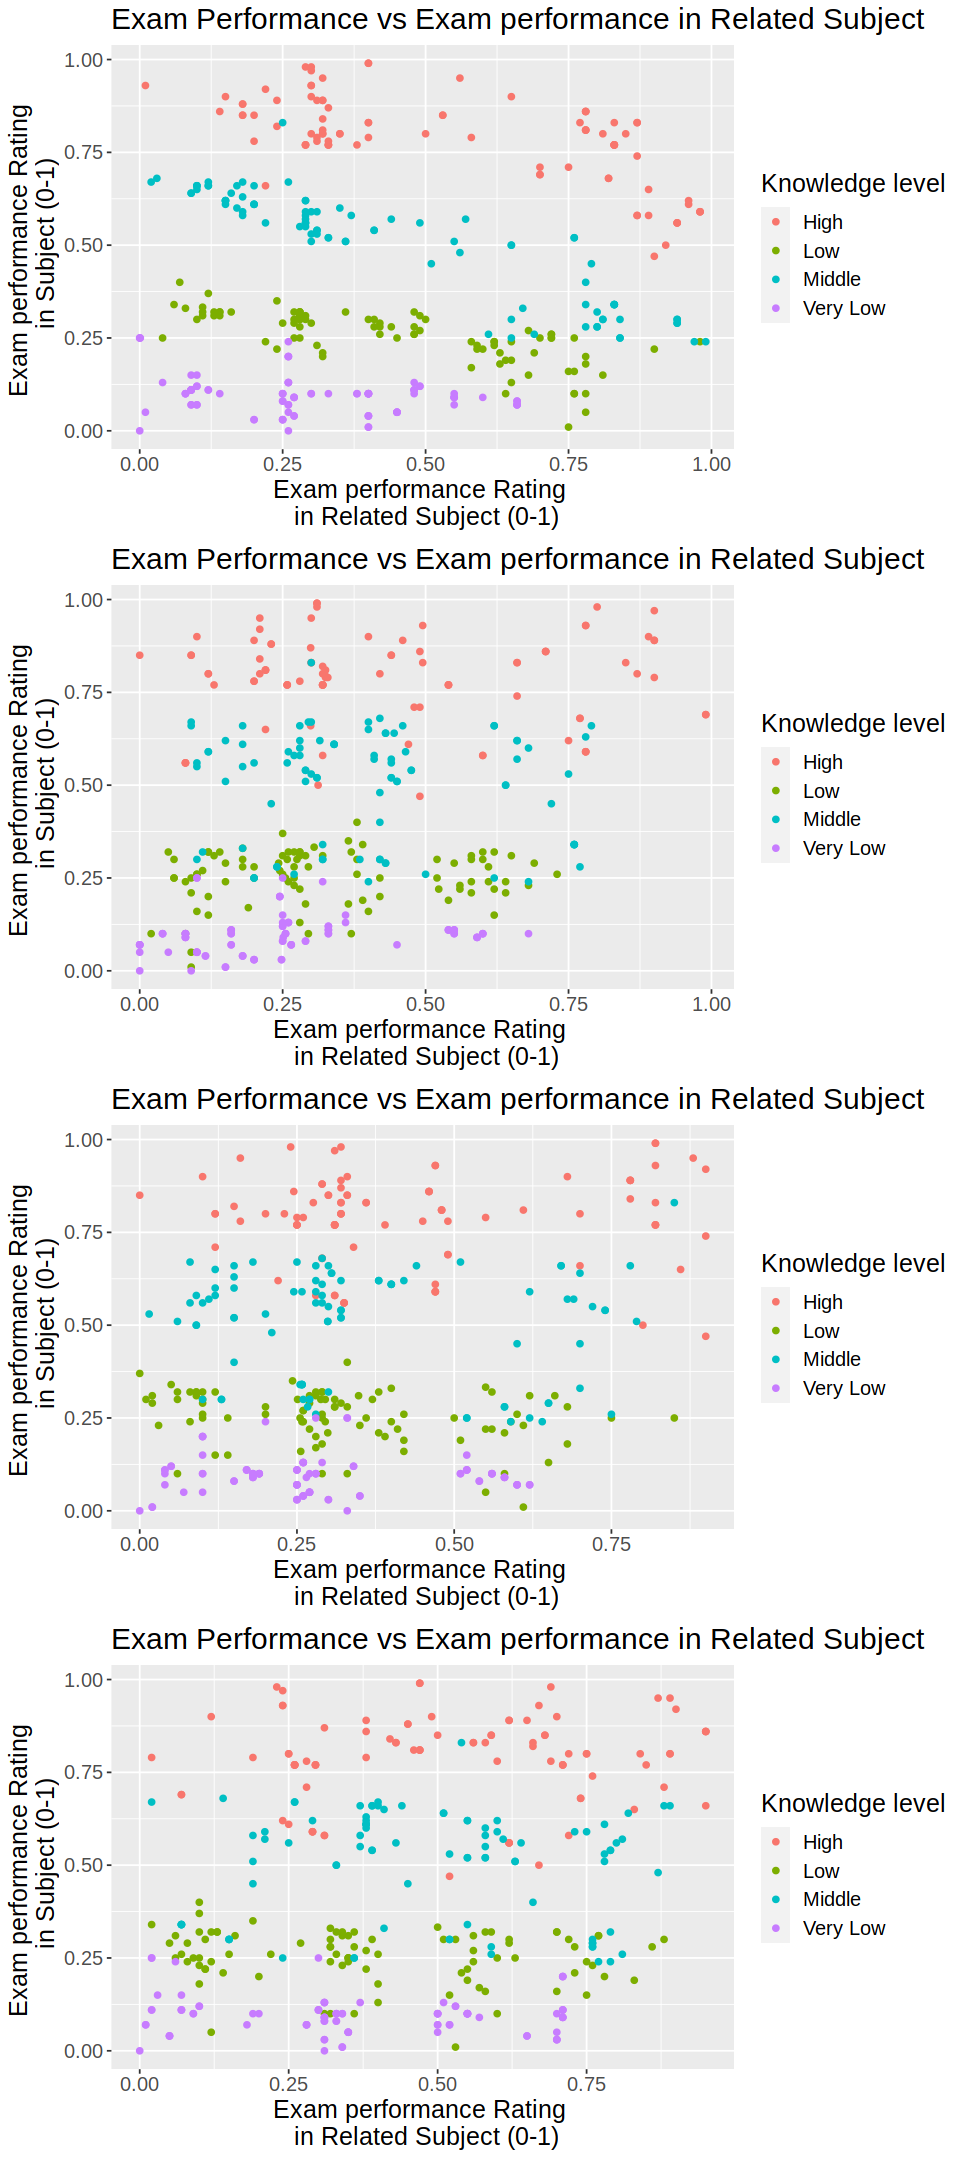

In [34]:
options(repr.plot.height = 18, repr.plot.width = 8)
data_plot_LPR_PEG <- ggplot(knowledge_data_split_train, aes(x= LPR,y= PEG, color = UNS))+
    geom_point() +
    labs(x="Exam performance Rating \n in Related Subject (0-1)", y= "Exam performance Rating \n in Subject (0-1)", color = "Knowledge level")+
    ggtitle("Exam Performance vs Exam performance in Related Subject")+
    theme(text = element_text(size = 15))


data_plot_STG_PEG <- ggplot(knowledge_data_split_train, aes(x= STG,y= PEG, color = UNS))+
    geom_point() +
    labs(x="Exam performance Rating \n in Related Subject (0-1)", y= "Exam performance Rating \n in Subject (0-1)", color = "Knowledge level")+
    ggtitle("Exam Performance vs Exam performance in Related Subject")+
    theme(text = element_text(size = 15))


data_plot_SCG_PEG <- ggplot(knowledge_data_split_train, aes(x= SCG,y= PEG, color = UNS))+
    geom_point() +
    labs(x="Exam performance Rating \n in Related Subject (0-1)", y= "Exam performance Rating \n in Subject (0-1)", color = "Knowledge level")+
    ggtitle("Exam Performance vs Exam performance in Related Subject")+
    theme(text = element_text(size = 15))


data_plot_STR_PEG <- ggplot(knowledge_data_split_train, aes(x= STR,y= PEG, color = UNS))+
    geom_point() +
    labs(x="Exam performance Rating \n in Related Subject (0-1)", y= "Exam performance Rating \n in Subject (0-1)", color = "Knowledge level")+
    ggtitle("Exam Performance vs Exam performance in Related Subject")+
    theme(text = element_text(size = 15))



plot_grid(data_plot_LPR_PEG, data_plot_STG_PEG, data_plot_SCG_PEG, data_plot_STR_PEG, ncol = 1)

##### Plot 1: The Relationship Between the Variables  
    This plot represents the Virtualization of Relationship. It is clear from this plot that the all the different Variables can indeed distinctions between the different knowledge levels.

 #### 4. Parameter selection: Finding the best K value
Our next step is to find the best K value and selecting the predictor variables  which maximizes the accuracy for our model.

For selecting the predictor variables, we based it off of the research article where this dataset came from. The article mentioned that in predicting the user knowledge levels, the most useful variable to consider are the Study time rating(STG), the Repetition rating( SCG), the exam performance rating(PEG) of the subject, the Study time rating(STR) of related subjects, and the exam performance rating in related subjects(LPR). Basically all the variables (ref). And from Plot 1, we can also see that indeed distinctions between the different knowledge levels can be made with all the different variables. 

For selecting the K  variable, where K is the number of neighbors. We will be using cross-validation with validation set of 5 in the training set to find the best possible k value. In other words, we will split our
training data into 5 training sets. 

Firstly, we apply nearest_neighbor, set_engine, and set_mode
functions to create a model specification. Inside the nearest_neighbor function, the argument
`weight_func` is set to rectangular, which means each k neighbor are equally important. For
the neighbors argument, `tune()` is telling the framework to find the different parameter values
for K.

Since KNN classification uses Euclidean distance between points, so it is very sensitive
to the different types of scale. Thus, we planned to standardize the variables for all chosen
variables to ensure the predictive algorithms are accurate and unbiased. We managed to
standardize all the variables by using the recipe function with `step_center(all_predictors())` and
`step_scale(all_predictors())`.

For cross-validation, we use `vfold_cv` function to set the validation set into 5 folds
by using the training set. Finally, we create a tribble with neighbors and use the seq function to
set the K-values to odd numbers (e.g., 1,3,5... 𝑛). The reason why we don’t want even
numbers is because each neighbor is equally weighted; therefore, the even numbers will
cause confusion.

Finally, we put everything into workflow to chain all the steps together to get the
accuracy of different K-values. 
 


In [8]:

##Finding the k value for best accuracy
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

##Choosing all the variables as predictors, and standardize it
data_recipe <- recipe(UNS ~. , data = knowledge_data_split_train)|>
  step_center(all_predictors())|>
  step_scale(all_predictors())

training_vfold <-  vfold_cv(knowledge_data_split_train, v=5, strata = UNS)

k_value = 101
K <- tibble(neighbors = seq(1,k_value,2))

knn_result <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_tune)|>
  tune_grid(resamples = training_vfold, grid = K) |>
  collect_metrics()|>
  filter(.metric == "accuracy")
knn_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8555556,5,0.02348824,Preprocessor1_Model01
3,accuracy,multiclass,0.8388889,5,0.02389535,Preprocessor1_Model02
5,accuracy,multiclass,0.8000000,5,0.03474999,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
97,accuracy,multiclass,0.6750000,5,0.02798534,Preprocessor1_Model49
99,accuracy,multiclass,0.6750000,5,0.02798534,Preprocessor1_Model50
101,accuracy,multiclass,0.6666667,5,0.02707443,Preprocessor1_Model51


##### Table 8: Accuracy of different K values  
    This table represents the Accuracy of different K values from 1 to 101, Advancing by 2

#### 5. Visualizing the optimal K-value

We used the ggplot function to create a line graph which
helps to visualize the accuracy trends under corresponding K-values. Surprisingly, when the
K=1, we have the most accurate K-value for the model. Thus, we choose K equals to one as
our optimal K-value.

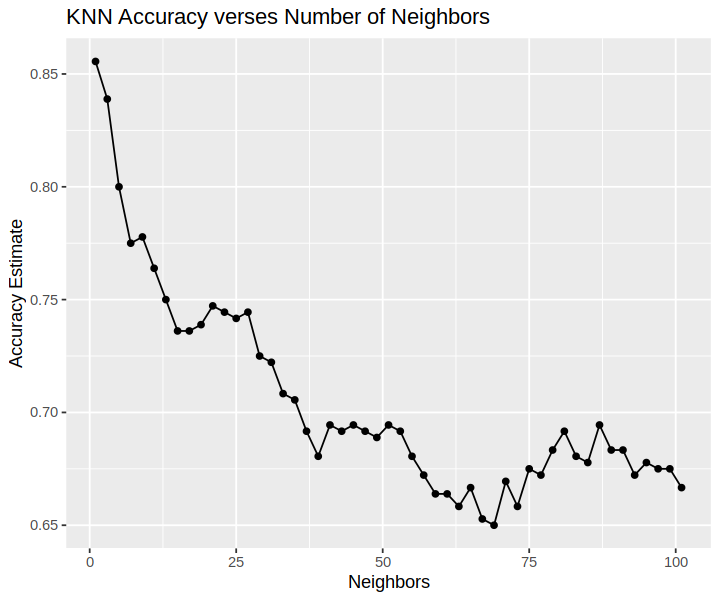

In [9]:
##Scatter plot on the accuracy and number of neighbors
cross_val_plot <- ggplot(knn_result, aes(x=neighbors, y= mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle(label= "KNN Accuracy verses Number of Neighbors")
cross_val_plot

##### Plot 2: KNN Accuracy verses Number of Neighbors
    This plot represents the Virtualization of "Table 7". Notably, the Highest accuracy came from a K neighbor of 1.

#### 6. Creating the model with the optimal K-value

In [10]:
##Finding confusion matrix of model using testing set
knn_best_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")


knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_best_tune)|>
  fit(knowledge_data_split_train)


#### 7. Predicting the model on the testing data set, and evaluating the model

we are planning to calculate the corresponding
accuracy, for all the diagonal entries (where 𝑖 = 𝑗). Since the confusion
matrix is in the list, we first convert it into matrix form.
For the accuracy calculation, we apply the formula: $$𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦 = \frac{𝑁𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛} {𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠}$$ ,
where the number of correct predictions are the diagonal entries, and the total number of
predictions are the sum of all entries. In R, we can simply calculate the accuracy by:
sum(diag(matrix))/sum(matrix)

In [11]:
## Predicting the UNS of testing data set
knowledge_predictions= knn_fit|>
  predict(knowledge_data_split_test)|>
  bind_cols(knowledge_data_split_test)
knowledge_predictions


.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
High,0.28,0.16,0.69,0.33,0.78,High
High,0.48,0.30,0.15,0.65,0.77,High
High,0.31,0.82,0.47,0.40,0.99,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Very Low,0.25,0.05,0.53,0.10,0.12,Very Low
Very Low,0.26,0.26,0.31,0.26,0.13,Very Low
Low,0.52,0.28,0.32,0.10,0.10,Very Low


##### Table 9: Predicted knowledge levels
    This table represents the predicted knowledge level using the model, with the original testing set(Table 7). 

In [12]:
knowledge_metrics= knowledge_predictions|>
  metrics(truth= UNS, estimate = .pred_class)|>
  filter(.metric== "accuracy")
knowledge_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9294872


##### Table 10: Accuracy of the model
    This table represents the Accuracy of our model, ie 𝑁𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛 / 𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠
    Looking at the value of the .estimate variable, it shows that our model has an estimated accuracy on the testing set of ~92.9%

In [13]:
knowledge_conf_mat= knowledge_predictions|>
  conf_mat(truth= UNS, estimate = .pred_class)
knowledge_conf_mat

          Truth
Prediction High Low Middle Very Low
  High       38   0      1        0
  Low         0  31      0        1
  Middle      1   4     38        0
  Very Low    0   4      0       38

##### Table 11: Confusion matrix 
    This table represents the true number of each Knowledge level, and the predicted number of each Knowledge level.
    The left column represents the predicted number of obseravtions, and the row represents the true number of obseravtions.
    Looking at the table, The highest number of missed predictions of the Knowledge level came from the "low" class, 
    with a total of 8 missed predictions. All the other Knowledge level had only one missed predictions.

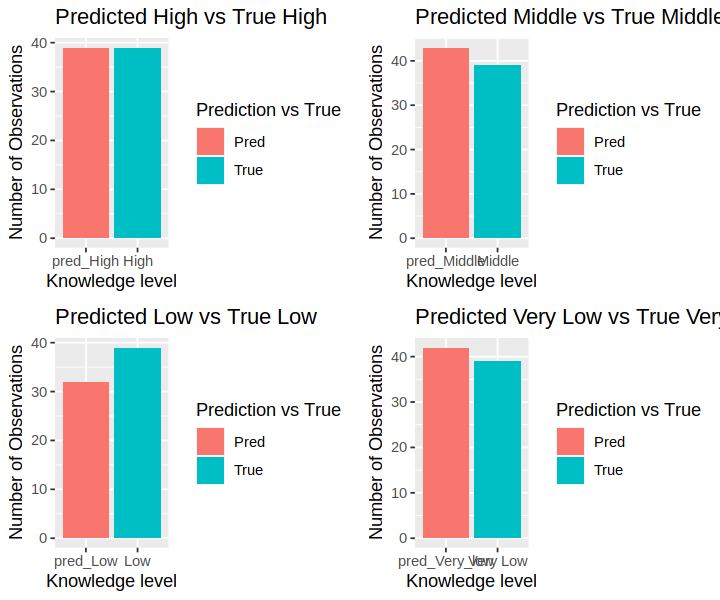

In [15]:
options(repre.plot.width= 11, reper.plot.height = 9)

#Number of Predicted cases 
count <- knowledge_predictions|>
    group_by(.pred_class) |>
    summarize(count = n())|>
    rename(UNS = .pred_class)|>
    mutate(UNS = fct_recode(UNS, pred_High = "High", pred_Low = "Low", pred_Middle = "Middle", pred_Very_low = "Very Low"))

#Number of True cases 
count2 <- knowledge_predictions|>
    group_by(UNS) |>
    summarize(count = n())

## Combining the Number of Predicted cases with Number of True cases 
count3 <- rbind(count, count2)|>
    mutate(pred_or_true = UNS)|>
     mutate(pred_or_true = fct_recode(UNS, Pred = "pred_High", Pred = "pred_Low", Pred = "pred_Middle", Pred = "pred_Very_low",
                                     True = "High",
                                     True = "Low",
                                     True = "Middle",
                                     True = "Very Low"))

Compare_High <- count3|>
    filter(UNS == "pred_High" | UNS== "High") |>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted High vs True High")

Compare_Middle <- count3|>
    filter(UNS == "pred_Middle" | UNS== "Middle") |>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted Middle vs True Middle")


Compare_Low <- count3|>
    filter(UNS== "pred_Low" | UNS== "Low")|>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted Low vs True Low")

Compare_Very_Low <- count3|>
    filter(UNS== "pred_Very_low" | UNS== "Very Low")|>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted Very Low vs True Very Low")

plot_grid(Compare_High, Compare_Middle,Compare_Low, Compare_Very_Low, ncol = 2)

##### Plot 2: Predicted vs True
    This plot compares the amounts of true with the predicted number of each class levels. 

Discussion:
 
Using the optimal k-value (k=1) for the knn algorithm, our model has predicted the knowledge level for each student in the dataset. The accuracy rate is 93% (rounded up to the nearest percent). Overall, our model’s prediction tends to correspond with the labeled category of student performance. Therefore, we conclude that our model can accurately predict student performance in this data set.
 
Our model’s predictions have not shown too much discrepancy in the accuracy across the four categories. However, it should be noted that our model has highest accuracy in predicting the category labeled as “High”, with only one missed prediction, and is less accurate in predicting the category labeled as “Low”, with 8 missed predictions in a total of 39 observations(table 11). Although 8 is not large enough to be considered as a remarkable number, the cause for this difference is worth potential future investigation.
 
Overall, this result of this analysis is what we anticipated in our hypothesis. With a 93% accuracy rate, most of the predictions align with their labeled category in this dataset. However, our analysis based on the knn algorithm does not provide sufficient information to compare the significance of different variables on the labeled categories.
 
This model provides valuable real-life applications as it could potentially be applied to the current education system. Compared to the traditional letter grade grading system, the system used in this dataset has more criteria that brings in a more diverse perspective to assessing student learning. Our algorithm could help bring this system into practical use by using the algorithm to assign the category instead of human assignment(educators, authorities etc.), which avoids subjective bias. This could also allow this grading system to be applied across different educational institutions as the category assignment is universal and objective, in which the influence that the discrepancy between each individual graders has on the result could be minimized. 
 
Looking at the potential real life application of this model, it leads the way to future questions such as: How can we adapt the model to predict the knowledge level for a data set that incorporates more variables? This question is worth investigation as the criterion for this grading system could be modified or extended to fit more educational needs of different institutions.

Another future question could be targeted towards finding out which one out of the five variables has more influence on an individual’s knowledge level in this dataset. This question was originally proposed in our hypothesis, however, the findings of this analysis focused on the overall categorical prediction instead of comparing the significance across the five variables. In future investigation, we could focus on evaluating the relevance of each variable on the knowledge level by using the forward selection method that produces the optimal number of relevant variables (predictors). By comparing the accuracy of the five single-predictor combinations, we can tell which predictor has higher accuracy and is therefore more significant in predicting the knowledge level. If any variable is found to be rather irrelevant to predicting the knowledge level, it could be filtered out and thus improve the accuracy of the model. 



References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.